# INTRODUCCIÓN

Este trabajo tiene como objetivo mostrar el potencial de predicción de la producción de energía eólica a nivel de regiones. En particular, se tomarán datos meteorológicos como entrada para predecir la potencia media ofrecida por todos los aereogeneradores de la región de Mancha Oriental por cada hora.

In [ ]:
import os
import xarray as xr
import pandas as pd
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# LECTURA Y PROCESAMIENTO DE DATOS

In [ ]:
ROOT = '/content/drive/MyDrive/Redes Neuronales'
data = xr.open_dataset(os.path.join(ROOT, 'MANORI_wind100_6060_2018_L0.nc4'))
data

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 60, lon: 60)
Coordinates:
    number   int64 ...
    reftime  (time) datetime64[ns] ...
    surface  float64 ...
  * lat      (lat) float64 42.9 42.8 42.7 42.6 42.5 ... 37.4 37.3 37.2 37.1 37.0
  * lon      (lon) float64 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 ... 0.4 0.5 0.6 0.7 0.8
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    u100     (time, lat, lon) float32 ...
    v100     (time, lat, lon) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-02-07T11:04 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# CONCATENAMOS EL RESTO DE AÑOS
for year in [2019,2020,2021]:
  data = xr.concat([data,xr.open_dataset(os.path.join(ROOT, f'MANORI_wind100_6060_{year}_L0.nc4'))], dim='time')
data

<xarray.Dataset>
Dimensions:  (time: 35064, lat: 60, lon: 60)
Coordinates:
    number   int64 0
    reftime  (time) datetime64[ns] 2018-01-01 2018-01-01 ... 2021-12-31T12:00:00
    surface  float64 0.0
  * lat      (lat) float64 42.9 42.8 42.7 42.6 42.5 ... 37.4 37.3 37.2 37.1 37.0
  * lon      (lon) float64 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 ... 0.4 0.5 0.6 0.7 0.8
  * time     (time) datetime64[ns] 2018-01-01 ... 2021-12-31T23:00:00
Data variables:
    u100     (time, lat, lon) float32 5.085 5.443 6.542 ... -3.326 -3.536 -3.726
    v100     (time, lat, lon) float32 1.703 1.372 0.8333 ... -0.5425 -0.482
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-02-07T11:04 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
data['time'].values[0:14] # HORA DEL MAPA DE VIENTO PREDICHO

array(['2018-01-01T00:00:00.000000000', '2018-01-01T01:00:00.000000000',
       '2018-01-01T02:00:00.000000000', '2018-01-01T03:00:00.000000000',
       '2018-01-01T04:00:00.000000000', '2018-01-01T05:00:00.000000000',
       '2018-01-01T06:00:00.000000000', '2018-01-01T07:00:00.000000000',
       '2018-01-01T08:00:00.000000000', '2018-01-01T09:00:00.000000000',
       '2018-01-01T10:00:00.000000000', '2018-01-01T11:00:00.000000000',
       '2018-01-01T12:00:00.000000000', '2018-01-01T13:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
data['reftime'].values[0:14] # MOMENTO EN QUE SE REALIZÓ LA PREDICCIÓN -> CADA 12 HORAS

array(['2018-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-01-01T12:00:00.000000000', '2018-01-01T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
# COMPONENTE RHO
rho = np.sqrt(data['u100'].values**2 + data['v100'].values**2)
# COMPONENTE SIN
sin = data['v100'].values / rho
# COMPONENTE COS
cos = data['u100'].values / rho
datos_procesados = np.stack((rho, sin, cos), axis=3)
datos_procesados.shape


(35064, 60, 60, 3)

In [ ]:
# LECTURA DE CSV
labels = pd.read_csv(os.path.join(ROOT, 'MANORI_utc_20150101_20221231.csv'), delimiter=';')
labels['utctime_datetime'] = [datetime.strptime(cadena_fecha, "%Y-%m-%d %H:%M") for cadena_fecha in labels['utctime']]
labels['utctime_datetime'].values

array(['2015-01-01T00:00:00.000000000', '2015-01-01T01:00:00.000000000',
       '2015-01-01T02:00:00.000000000', ...,
       '2022-12-31T21:00:00.000000000', '2022-12-31T22:00:00.000000000',
       '2022-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
fechas = pd.DataFrame({'utctime_datetime': data['time'].values})
labels = pd.merge(labels, fechas, on='utctime_datetime')
labels

,utctime,Produccion,Consigna,Tanto por 1,utctime_datetime
0,2018-01-01 00:00,2503.50,3521.54,0.710911,2018-01-01 00:00:00
1,2018-01-01 01:00,2263.78,3521.54,0.642838,2018-01-01 01:00:00
2,2018-01-01 02:00,1999.13,3521.54,0.567686,2018-01-01 02:00:00
3,2018-01-01 03:00,781.78,3521.54,0.221999,2018-01-01 03:00:00
4,2018-01-01 04:00,706.53,3521.54,0.200631,2018-01-01 04:00:00
...,...,...,...,...,...
35059,2021-12-31 19:00,33.46,3653.74,0.009158,2021-12-31 19:00:00
35060,2021-12-31 20:00,66.83,3653.74,0.018291,2021-12-31 20:00:00
35061,2021-12-31 21:00,108.52,3653.74,0.029701,2021-12-31 21:00:00
35062,2021-12-31 22:00,145.08,3653.74,0.039707,2021-12-31 22:00:00


In [ ]:
y = labels['Produccion'].values #Tanto por 1
'''
y = 100*y
y.shape
'''

'\ny = 100*y\ny.shape\n'

In [ ]:
print(np.mean(y))
print(np.mean( np.abs(y-np.mean(y)) ))

837.3575270933152
569.8719047480708


In [ ]:
# COMPROBACIÓN DEL MERGE
np.all(labels['utctime_datetime'].values==data['time'].values)

True

In [ ]:
# SEPARACIÓN TRAIN VAL TEST
train_index = [i for i in range(len(data['time'].values)) if np.datetime64(data['time'].values[i], 'Y').astype(int)+1970 in [2018,2019]]
val_index = [i for i in range(len(data['time'].values)) if np.datetime64(data['time'].values[i], 'Y').astype(int)+1970 in [2020]]
test_index = [i for i in range(len(data['time'].values)) if np.datetime64(data['time'].values[i], 'Y').astype(int)+1970 in [2021]]

X_train = datos_procesados[train_index,:,:,:]
y_train = y[train_index]

X_val = datos_procesados[val_index,:,:,:]
y_val = y[val_index]

X_test = datos_procesados[test_index,:,:,:]
y_test = y[test_index]

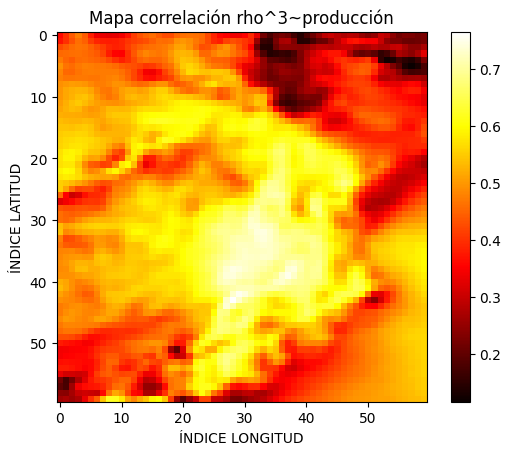

In [ ]:
h, w = 60, 60
correlaciones = np.zeros((h,w))
for i in range(h):
  for j in range(w):
    correlaciones[i,j] = np.corrcoef(X_train[:,i,j,0]**3, y_train)[0,1]

plt.imshow(correlaciones, cmap='hot', interpolation='nearest')
colorbar = plt.colorbar()
plt.title('Mapa correlación rho^3~producción')
plt.xlabel('ÍNDICE LONGITUD')
plt.ylabel('ÍNDICE LATITUD')
plt.savefig('im2.png')
plt.show()

In [ ]:
len(train_index), len(val_index), len(test_index)

(17520, 8784, 8760)

In [ ]:
17520+8784+8760

35064

# CREACIÓN DE LA ARQUITECTURA

In [ ]:
model = Sequential()
model.add(Conv2D(6, (5, 5), activation='relu', input_shape=(60, 60, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mean_absolute_error')
print(model.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          12832     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

# ENTRENAMIENTO

In [ ]:
# ENTRENAMIENTO
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/40
274/274 [==============================] - 10s 17ms/step - loss: 6.3429 - val_loss: 4.0067
Epoch 2/40
274/274 [==============================] - 2s 9ms/step - loss: 4.9454 - val_loss: 4.4841
Epoch 3/40
274/274 [==============================] - 2s 8ms/step - loss: 4.6928 - val_loss: 3.6421
Epoch 4/40
274/274 [==============================] - 2s 8ms/step - loss: 4.6233 - val_loss: 4.0446
Epoch 5/40
274/274 [==============================] - 2s 8ms/step - loss: 4.4998 - val_loss: 4.1123
Epoch 6/40
274/274 [==============================] - 2s 7ms/step - loss: 4.3723 - val_loss: 4.1468
Epoch 7/40
274/274 [==============================] - 3s 10ms/step - loss: 4.4094 - val_loss: 4.8758
Epoch 8/40
274/274 [==============================] - 2s 9ms/step - loss: 4.3581 - val_loss: 3.7203
Epoch 9/40
274/274 [==============================] - 2s 7ms/step - loss: 4.3506 - val_loss: 3.5807
Epoch 10/40
274/274 [==============================] - 2s 8ms/step - loss: 4.2445 - val_loss: 3.5

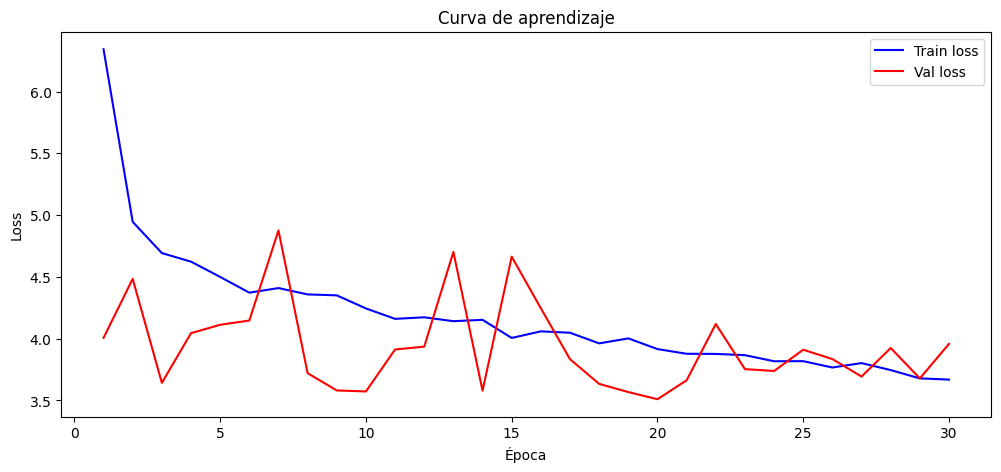

In [ ]:
# CURVA DE APRENDIZAJE - ES ÉPOCA 20
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_loss, 'b-', label='Train loss')
plt.plot(epochs, val_loss, 'r-', label='Val loss')
plt.title('Curva de aprendizaje')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(ROOT, 'learning_curve.pdf'))

In [ ]:
model.save(os.path.join(ROOT,'model.keras'))

# RESULTADOS

In [ ]:
model = load_model(os.path.join(ROOT,'model.keras'))

In [ ]:
preds = model.predict(X_test)
preds = np.squeeze(preds)
error_test = np.mean( np.abs(preds-y_test) )
print(error_test) # -> 3.62 << 16.00 (error de modelo == media)

274/274 [==============================] - 1s 3ms/step
3.616552530224501
